# Notebook 12 — Router Model Comparison (Prediction-Only)

This notebook compares the **two router models** on **prediction performance only**:

- **Random Forest router** trained in **Notebook 5**
- **XGBoost router** trained on the **same dataset + features** as Notebook 5

**Outputs (report-ready):**
- Accuracy, Macro-F1, Weighted-F1, Top-3 Accuracy
- Normalized confusion matrices (Top-K classes)
- Feature importance (Top 20) for both models
- Model-selection distribution comparison + agreement rate


In [7]:
import sys

print("Python:", sys.executable)
print("Version:", sys.version)

# install into THIS kernel env
!{sys.executable} -m pip -q install --upgrade pip setuptools wheel

# safest on SageMaker: conda-forge xgboost (no compile, matches lib)
!conda install -y -c conda-forge xgboost

# other deps
!{sys.executable} -m pip -q install s3fs joblib

Python: /home/ec2-user/anaconda3/envs/python3/bin/python
Version: 3.12.12 | packaged by conda-forge | (main, Jan 26 2026, 23:51:32) [GCC 14.3.0]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.5.3 requires httpx<1,>=0.25.0, which is not installed.
Retrieving notices: done
Channels:
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.11.0
    latest version: 26.1.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libxgboost-3.2.0           |   cpu_h2ebb00f_0        

In [1]:
import xgboost as xgb
print("xgboost version:", xgb.__version__) 

xgboost version: 3.2.0


## 1) Setup and dependencies


In [2]:
import numpy as np
import pandas as pd
import boto3
import sagemaker
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt

Unable to load JumpStart region config.
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.12/site-packages/sagemaker/jumpstart/constants.py", line 69, in _load_region_config
    with open(filepath) as f:
         ^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/home/ec2-user/anaconda3/envs/python3/lib/python3.12/site-packages/sagemaker/jumpstart/region_config.json'


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## 2) S3 paths (inputs from Notebook 5 + bucket discovery)


In [3]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
region = boto3.Session().region_name
print("Region:", region)
print("Bucket:", bucket)

# Notebook 5 outputs (expected locations used in your pipeline)
req_s3 = f"s3://{bucket}/processed/synthetic_requests_labeled_v2.csv"
rf_model_s3 = f"s3://{bucket}/models/rf_router_v2.joblib"

print("req_s3:", req_s3)
print("rf_model_s3:", rf_model_s3)

Region: us-east-1
Bucket: sagemaker-us-east-1-907086662522
req_s3: s3://sagemaker-us-east-1-907086662522/processed/synthetic_requests_labeled_v2.csv
rf_model_s3: s3://sagemaker-us-east-1-907086662522/models/rf_router_v2.joblib


## 3) Load labeled synthetic requests + Random Forest router


In [4]:
requests = pd.read_csv(req_s3)
print("requests:", requests.shape)
display(requests.head(3))

tmp_rf = "/tmp/rf_router_v2.joblib"
!aws s3 cp {rf_model_s3} {tmp_rf}

rf = joblib.load(tmp_rf)
print("✅ Loaded RF model:", type(rf))


/home/ec2-user/anaconda3/envs/python3/lib/python3.12/site-packages/fsspec/registry.py:301: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


requests: (40000, 11)


,prompt_tokens,output_tokens,tokens_total,domain,latency_requirement_ms,quality_req_tier,quality_requirement,log_tokens_total,strict_latency,domain_penalty,label_model
0,2103,1217,3320,writing,200,4,0.725,8.108021,1,0.04,Gemini 3
1,2353,1094,3447,reasoning,3000,3,0.600,8.145550,0,0.08,Claude 3.6S
2,511,475,986,chat,400,1,0.350,6.894670,1,0.00,Gemini 3


download: s3://sagemaker-us-east-1-907086662522/models/rf_router_v2.joblib to ../../../../tmp/rf_router_v2.joblib
✅ Loaded RF model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>


## 4) Build the **same feature matrix** as Notebook 5 (robust to missing columns)


In [5]:
# The goal is to stay apples-to-apples with Notebook 5. 
# If a column is missing (depending on your saved dataset), we create a compatible fallback.

req = requests.copy()

# --- Base token fields ---
if "prompt_tokens" not in req.columns or "output_tokens" not in req.columns:
    raise ValueError("Expected columns prompt_tokens and output_tokens in synthetic_requests_labeled_v2.csv")

if "tokens_total" not in req.columns:
    req["tokens_total"] = req["prompt_tokens"].astype(int) + req["output_tokens"].astype(int)

if "log_tokens_total" not in req.columns:
    req["log_tokens_total"] = np.log1p(req["tokens_total"].astype(float))

# --- Latency requirement ---
# Notebook 5 commonly uses latency_requirement_ms; if missing, derive from latency_budget_s or latency_budget_ms
if "latency_requirement_ms" not in req.columns:
    if "latency_budget_s" in req.columns:
        req["latency_requirement_ms"] = (req["latency_budget_s"].astype(float) * 1000.0).round(0)
    elif "latency_budget_ms" in req.columns:
        req["latency_requirement_ms"] = req["latency_budget_ms"].astype(float)
    else:
        # conservative default if not present
        req["latency_requirement_ms"] = 2000.0

# strict_latency flag
if "strict_latency" not in req.columns:
    # heuristic: strict if <= 1200ms
    req["strict_latency"] = (req["latency_requirement_ms"].astype(float) <= 1200.0).astype(int)

# --- Quality requirement ---
# Notebook 5 uses quality_requirement; if missing, derive from min_tier or default mid requirement.
if "quality_requirement" not in req.columns:
    if "min_tier" in req.columns:
        tier_rank = {"low":0, "mid":1, "high":2}
        t = req["min_tier"].astype(str).str.strip().str.lower()
        req["quality_requirement"] = t.map({"low":0.25, "mid":0.55, "high":0.80}).fillna(0.55)
    else:
        req["quality_requirement"] = 0.55

# quality tier bucket
if "quality_req_tier" not in req.columns:
    req["quality_req_tier"] = pd.cut(
        req["quality_requirement"].astype(float),
        bins=[-1, 0.4, 0.7, 2],
        labels=["low","mid","high"]
    ).astype(str)

# quality_requirement_ms? (not needed)

# --- Domain ---
if "domain" not in req.columns:
    req["domain"] = "general"

# --- Label ---
if "label_model" not in req.columns:
    # Some variants may store label column under a different name
    candidates = [c for c in req.columns if "label" in c.lower() and "model" in c.lower()]
    raise ValueError(f"Expected label_model in dataset. Found label-ish columns: {candidates}")

# --- Assemble feature matrix in the same spirit as Notebook 5 ---
feature_cols = [
    "prompt_tokens","output_tokens","tokens_total","log_tokens_total",
    "latency_requirement_ms","quality_requirement","quality_req_tier","strict_latency"
]
X = req[feature_cols].copy()

# Domain one-hot
X = pd.get_dummies(pd.concat([X, req[["domain"]]], axis=1), columns=["domain"], drop_first=False)

# Category codes for labels (stable mapping)
y_cat = req["label_model"].astype("category")
label_names = list(y_cat.cat.categories)
y = y_cat.cat.codes.values

print("X shape:", X.shape)
print("Num classes:", len(label_names))


X shape: (40000, 13)
Num classes: 2


## 5) Train/test split (same seed, stratified)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (30000, 13) Test: (10000, 13)


## 6) Train XGBoost router on the same features


In [7]:
from xgboost import XGBClassifier

num_classes = int(len(label_names))

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=num_classes,
    n_estimators=400,
    max_depth=6,
    learning_rate=0.08,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
)

xgb.fit(X_train, y_train)
print("✅ Trained XGBoost")


✅ Trained XGBoost


In [9]:
print("y_test type:", type(y_test), "shape:", getattr(y_test, "shape", None))
rf_pred_tmp = rf.predict(X_test)
print("rf.predict type:", type(rf_pred_tmp), "shape:", getattr(rf_pred_tmp, "shape", None))

xgb_pred_tmp = xgb.predict(X_test)
print("xgb.predict type:", type(xgb_pred_tmp), "shape:", getattr(xgb_pred_tmp, "shape", None))

y_test type: <class 'numpy.ndarray'> shape: (10000,)
rf.predict type: <class 'numpy.ndarray'> shape: (10000,)
xgb.predict type: <class 'numpy.ndarray'> shape: (10000, 2)


In [10]:
print("y_test sample:", np.asarray(y_test)[:5])
print("rf_pred sample:", rf.predict(X_test)[:5])

y_test sample: [1 1 0 0 0]
rf_pred sample: [1 1 0 0 0]


## 7) Metrics comparison (Accuracy, F1, Top-3 Accuracy)


In [11]:
def top_k_accuracy(proba, y_true, k=3):
    k = min(k, proba.shape[1])  # safety if fewer classes exist
    topk = np.argsort(proba, axis=1)[:, -k:]
    ok = np.array([y_true[i] in topk[i] for i in range(len(y_true))])
    return float(ok.mean())

def eval_classifier(name, model, X_te, y_te):
    pred = model.predict(X_te)
    pred = np.asarray(pred)

    # FIX: if model returns probability / indicator matrix → convert to class labels
    if pred.ndim == 2:
        pred = pred.argmax(axis=1)

    proba = model.predict_proba(X_te)

    return {
        "model": name,
        "accuracy": float(accuracy_score(y_te, pred)),
        "macro_f1": float(f1_score(y_te, pred, average="macro")),
        "weighted_f1": float(f1_score(y_te, pred, average="weighted")),
        "top3_acc": float(top_k_accuracy(proba, y_te, k=3)),
    }

rf_metrics  = eval_classifier("RandomForest (Notebook 5)", rf, X_test, y_test)
xgb_metrics = eval_classifier("XGBoost (Notebook 12)", xgb, X_test, y_test)

metrics_df = pd.DataFrame([rf_metrics, xgb_metrics])
metrics_df

,model,accuracy,macro_f1,weighted_f1,top3_acc
0,RandomForest (Notebook 5),0.9998,0.999681,0.9998,1.0
1,XGBoost (Notebook 12),0.9994,0.999043,0.9994,1.0


### 7.1 Detailed classification reports


In [13]:
rf_pred  = rf.predict(X_test)

xgb_pred = xgb.predict(X_test)
xgb_pred = np.asarray(xgb_pred)
if xgb_pred.ndim == 2:
    xgb_pred = xgb_pred.argmax(axis=1)

print("=== RandomForest report ===")
print(classification_report(y_test, rf_pred, zero_division=0))

print("\n=== XGBoost report ===")
print(classification_report(y_test, xgb_pred, zero_division=0))

=== RandomForest report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8056
           1       1.00      1.00      1.00      1944

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000


=== XGBoost report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8056
           1       1.00      1.00      1.00      1944

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [14]:
print("Unique labels in y_test:", np.unique(y_test))
print("Baseline majority accuracy:", np.max(np.bincount(y_test)) / len(y_test))

Unique labels in y_test: [0 1]
Baseline majority accuracy: 0.8056


## 8) Confusion matrices (normalized; Top-K classes)


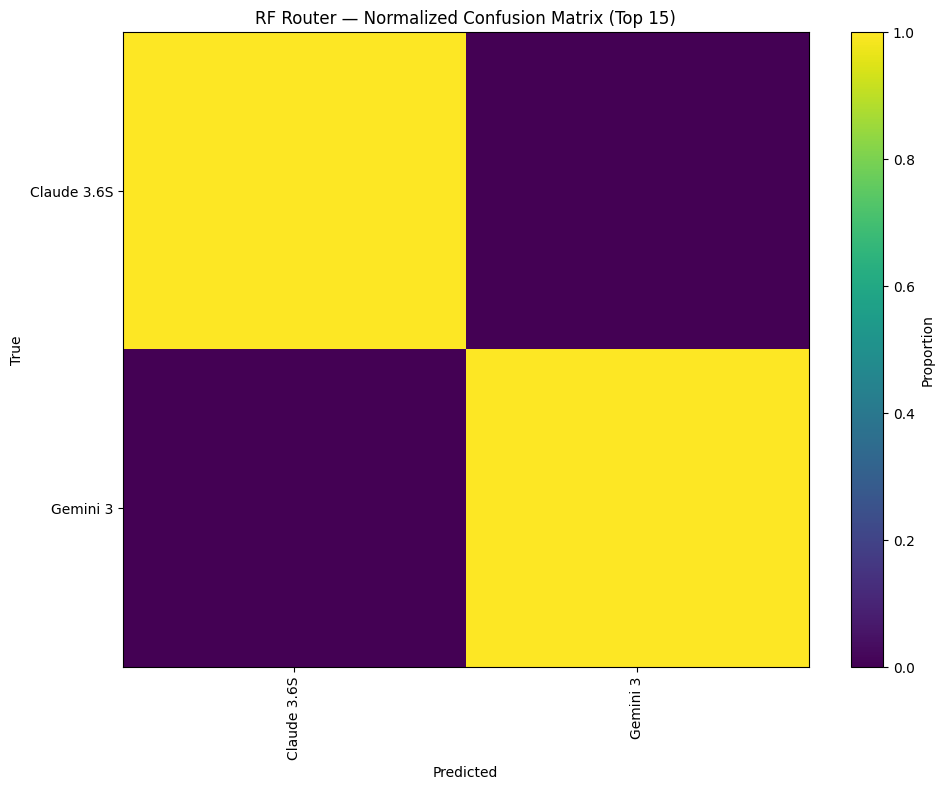

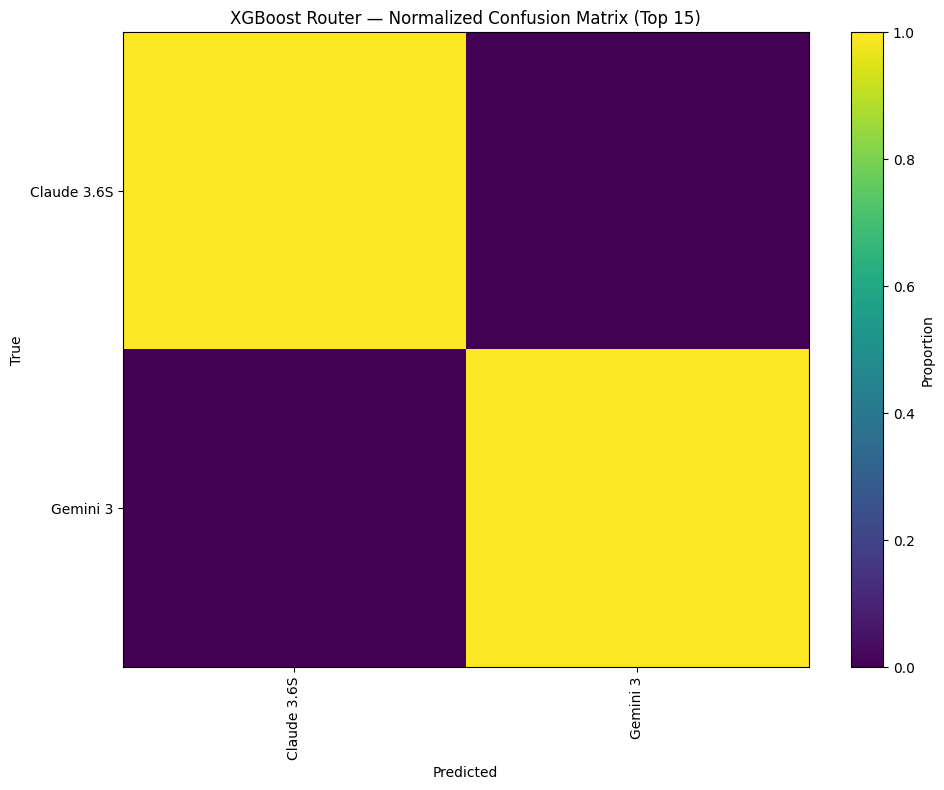

In [15]:
def plot_confusion_topk(y_true_codes, y_pred_codes, title, K=15):
    y_true_names = pd.Series([label_names[i] for i in y_true_codes])
    y_pred_names = pd.Series([label_names[i] for i in y_pred_codes])

    top_classes = y_true_names.value_counts().head(K).index.tolist()

    mask = y_true_names.isin(top_classes) & y_pred_names.isin(top_classes)
    y_true_k = y_true_names[mask]
    y_pred_k = y_pred_names[mask]
    labels_k = top_classes

    cm = confusion_matrix(y_true_k, y_pred_k, labels=labels_k)
    cm_norm = cm / np.maximum(cm.sum(axis=1, keepdims=True), 1)

    plt.figure(figsize=(10, 8))
    plt.imshow(cm_norm, aspect="auto")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(len(labels_k)), labels_k, rotation=90)
    plt.yticks(range(len(labels_k)), labels_k)
    plt.colorbar(label="Proportion")
    plt.tight_layout()
    plt.show()

plot_confusion_topk(y_test, rf_pred,  "RF Router — Normalized Confusion Matrix (Top 15)")
plot_confusion_topk(y_test, xgb_pred, "XGBoost Router — Normalized Confusion Matrix (Top 15)")


## 9) Feature importance (Top 20)


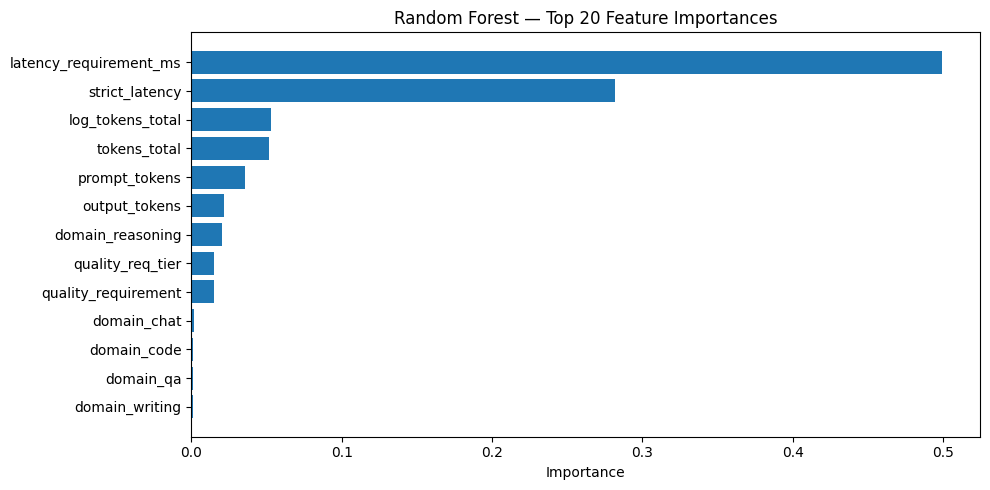

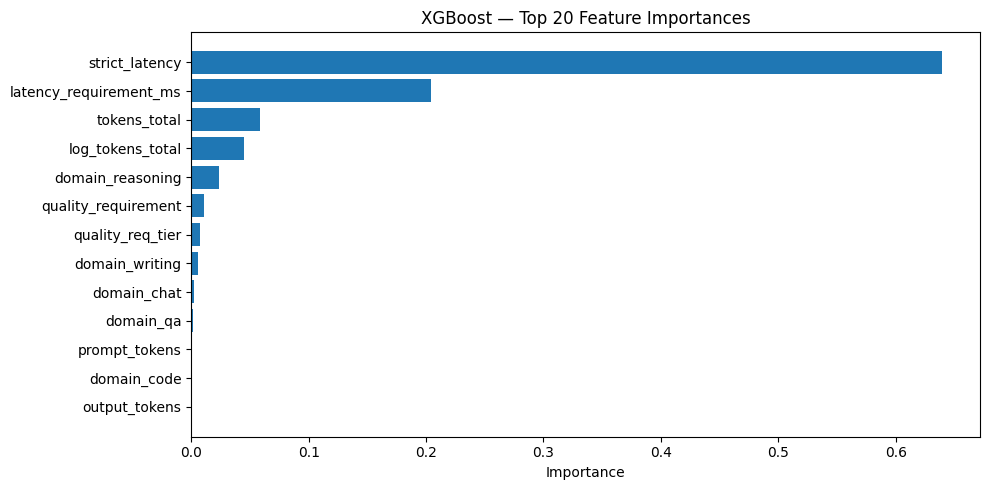

In [16]:
# RF importance
rf_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20).sort_values()
plt.figure(figsize=(10,5))
plt.barh(rf_imp.index, rf_imp.values)
plt.title("Random Forest — Top 20 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# XGB importance
xgb_imp = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20).sort_values()
plt.figure(figsize=(10,5))
plt.barh(xgb_imp.index, xgb_imp.values)
plt.title("XGBoost — Top 20 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## 10) Model selection distribution + agreement rate


In [17]:
rf_pred_names  = pd.Series([label_names[i] for i in rf_pred])
xgb_pred_names = pd.Series([label_names[i] for i in xgb_pred])

# Agreement rate
agree = float((rf_pred == xgb_pred).mean())
print("RF vs XGB agreement rate:", round(agree, 4))

# Top predicted models (side-by-side)
topN = 12
rf_top  = rf_pred_names.value_counts().head(topN)
xgb_top = xgb_pred_names.value_counts().head(topN)

dist = pd.DataFrame({"RF": rf_top, "XGB": xgb_top}).fillna(0).astype(int)
dist


RF vs XGB agreement rate: 0.9996


,RF,XGB
Claude 3.6S,8054,8050
Gemini 3,1946,1950


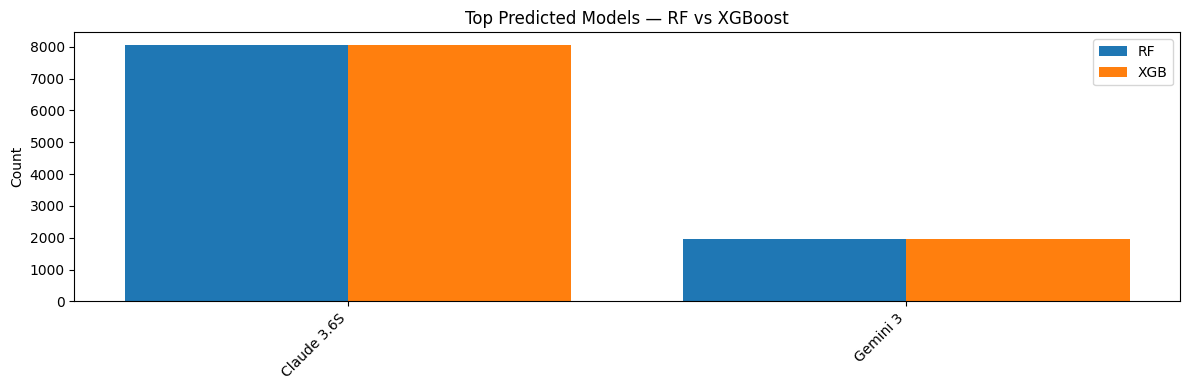

In [18]:
# Plot distribution (Top N combined)
top_models = list(pd.Index(dist.index).unique())
x = np.arange(len(top_models))
rf_counts = dist["RF"].reindex(top_models).values
xgb_counts = dist["XGB"].reindex(top_models).values

plt.figure(figsize=(12,4))
plt.bar(x - 0.2, rf_counts, width=0.4, label="RF")
plt.bar(x + 0.2, xgb_counts, width=0.4, label="XGB")
plt.xticks(x, top_models, rotation=45, ha="right")
plt.title("Top Predicted Models — RF vs XGBoost")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


## 12) Final summary table (copy/paste into report)


In [19]:
summary = metrics_df.copy()
summary


,model,accuracy,macro_f1,weighted_f1,top3_acc
0,RandomForest (Notebook 5),0.9998,0.999681,0.9998,1.0
1,XGBoost (Notebook 12),0.9994,0.999043,0.9994,1.0


### Notes for your report

- This notebook compares routers on **prediction quality** only (no cost/SLA simulation).
- If you want cost/SLA outcomes later, that requires an explicit pricing + latency proxy and feasibility checks to be defined consistently across notebooks.
